In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset
import os

In [98]:
train_dir = 'data/our_train'
val_dir = 'data/our_val'

train_samples = dict()
for c in os.listdir(train_dir):
    train_samples[c] = len(os.listdir(f'{train_dir}/{c}'))
    
val_samples = dict()
for c in os.listdir(val_dir):
    val_samples[c] = len(os.listdir(f'{val_dir}/{c}'))

print('Train:')
print(train_samples)
print(sum(train_samples.values()))
print('Validation:')
print(val_samples)

Train:
{'i': 184, 'iii': 132, 'vi': 128, 'v': 138, 'vii': 136, 'iv': 198, 'ii': 111, 'viii': 140, 'x': 126, 'ix': 165}
1458
Validation:
{'i': 78, 'iii': 56, 'vi': 54, 'v': 59, 'vii': 58, 'iv': 84, 'ii': 47, 'viii': 60, 'x': 54, 'ix': 70}


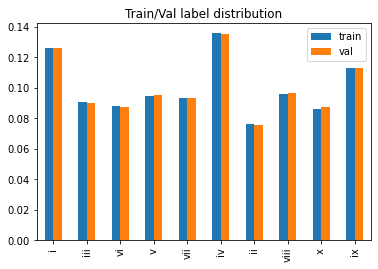

In [104]:
df = pd.DataFrame({'train': train_samples, 'val': val_samples})
df = df / df.sum(axis=0)
df.plot(kind='bar',
        stacked=False,
        title='Train/Val label distribution')
plt.show()

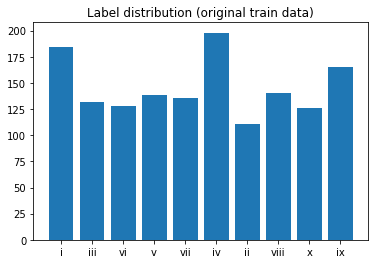

In [99]:
plt.bar(train_samples.keys(), train_samples.values())
plt.title('Label distribution (original train data)')
plt.show()

In [45]:
"""All code in this cell is imported from the script run_train_eval.py"""

def imshow(inp, title=None):
    """Imshow for Tensors."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15, 15))
    plt.imshow(inp)
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, fontsize=25)
    plt.pause(0.001)

BATCH_SIZE = 16
# Resize the samples and transform them into tensors
data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])

# Create a pytorch dataset from a directory of images
train_dataset = datasets.ImageFolder(train_dir, data_transforms)
val_dataset = datasets.ImageFolder(val_dir, data_transforms)

class_names = train_dataset.classes

# Dataloaders initialization
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [59]:
train_labels = np.array([x[1] for x in train_dataset.imgs])
class_mapping = train_dataset.class_to_idx
rev_class_mapping = {v: k for k, v in class_mapping.items()}

In [41]:
train_dataset_per_class = {c: torch.utils.data.DataLoader(Subset(train_dataset, np.where(train_labels == class_mapping[c])[0]), 
                                                          batch_size=BATCH_SIZE, shuffle=True) 
                           for c in class_names}

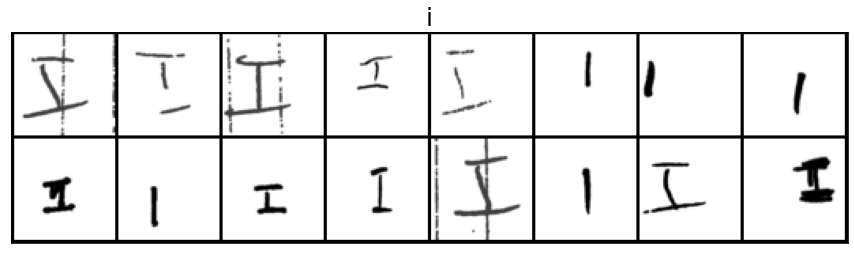

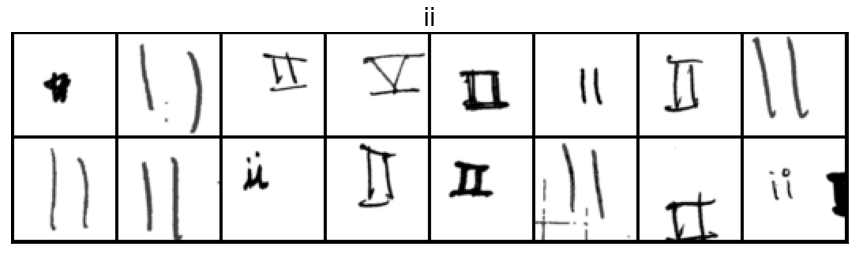

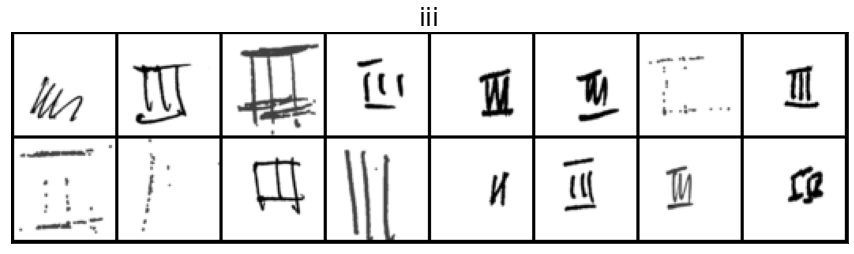

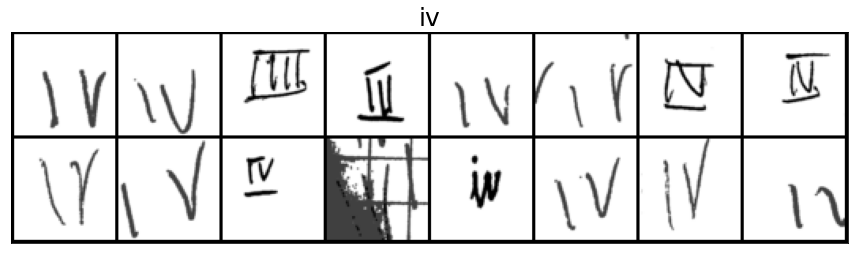

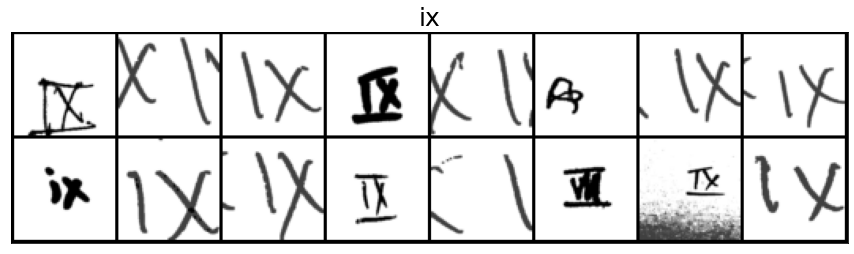

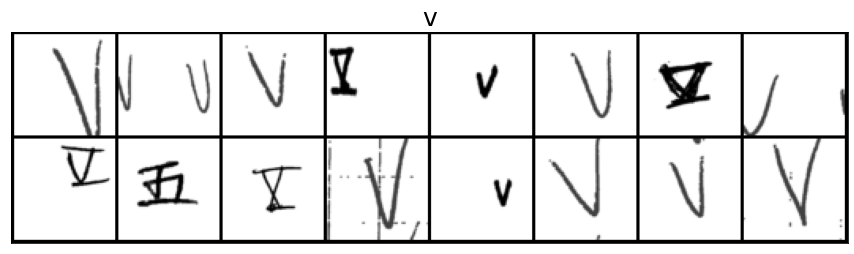

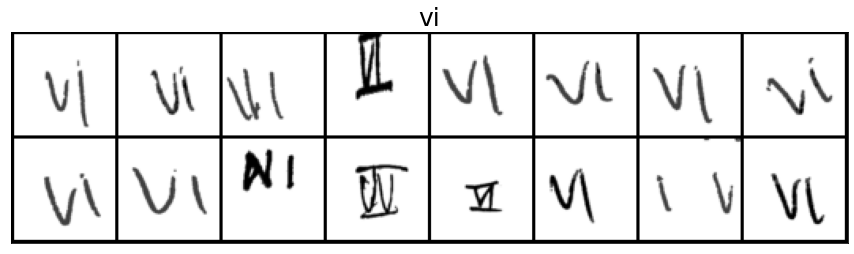

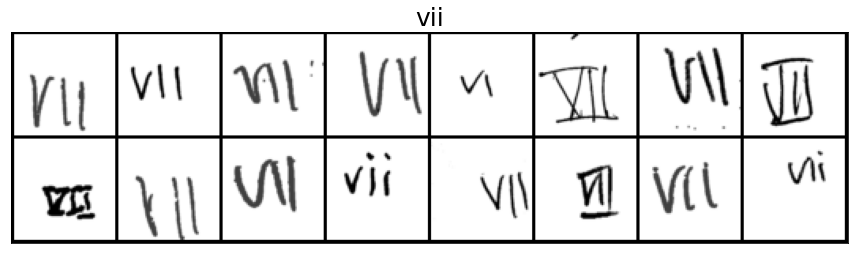

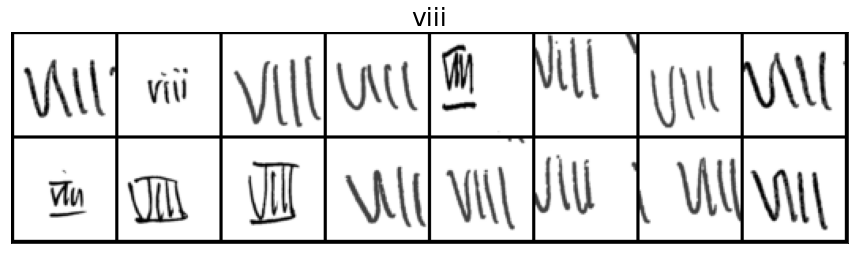

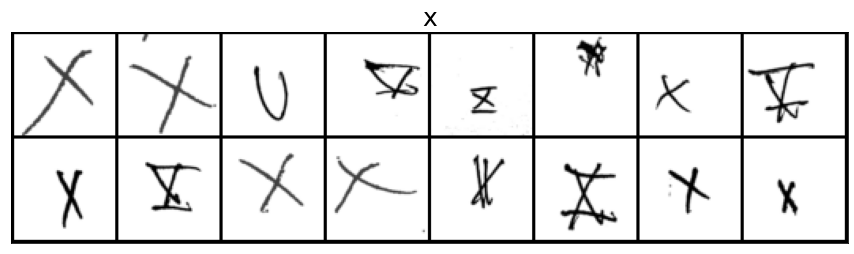

In [46]:
for c in class_names:
    inputs, classes = next(iter(train_dataset_per_class[c]))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=c)

We can observe that most data is labeled correctly, although some weird images appear.

## Clustering

In [85]:
X_train = []
y_train = []
for imgs, labels in train_dataloader:
    X_train.append(imgs.numpy().transpose((0, 2, 3, 1)).reshape(-1, 3*64*64))
    y_train.append(labels.numpy())

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
y_train = np.array(list(map(lambda y: rev_class_mapping[y], y_train)))

print(X_train.shape)
print(y_train.shape)

(2067, 12288)
(2067,)


In [90]:
def imshow_np(inp, title=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(inp.reshape(64,64,3))
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, fontsize=25)

[0.99572295 0.995723   0.995723   ... 0.9943347  0.9943347  0.9943347 ]
[0.99572545 0.9957254  0.99572545 ... 0.99463135 0.99463135 0.99463135]
[0.9954423  0.99544233 0.9954423  ... 0.9940296  0.9940296  0.9940296 ]
[0.99515456 0.99515456 0.99515456 ... 0.99324673 0.99324673 0.99324673]
[0.995338  0.995338  0.9953379 ... 0.993474  0.993474  0.993474 ]


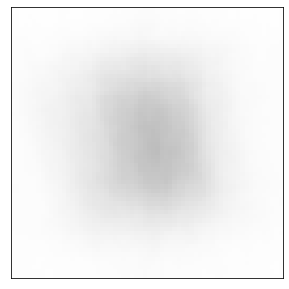

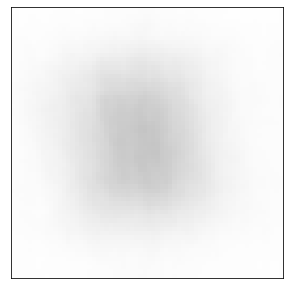

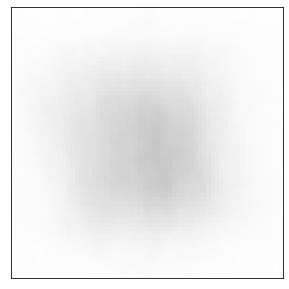

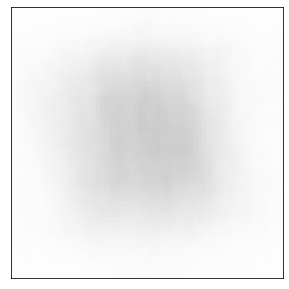

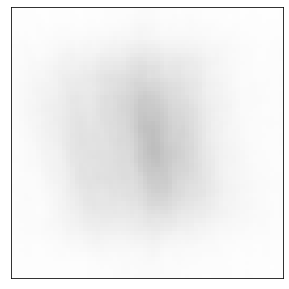

In [93]:
from sklearn.decomposition import PCA, NMF

pca = PCA(n_components=5)
X_train_mean = np.mean(X_train, axis=0)
pca.fit(X_train - X_train_mean)
for princ_comp in pca.components_:
    print(princ_comp + X_train_mean)
    imshow_np(princ_comp + X_train_mean)

/anaconda/envs/hw_094295_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/anaconda/envs/hw_094295_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.6271126 0.6271126 0.6271126 ... 0.6364872 0.6364872 0.6364872]
[0.3023977 0.3023977 0.3023977 ... 0.2908964 0.2908964 0.2908964]
[0.10882293 0.10882293 0.10882293 ... 0.07990389 0.07990389 0.07990389]
[0.23710862 0.23710862 0.23710862 ... 0.2371434  0.2371434  0.2371434 ]
[0.17463304 0.17463304 0.17463304 ... 0.16431813 0.16431813 0.16431813]


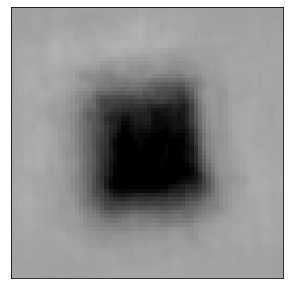

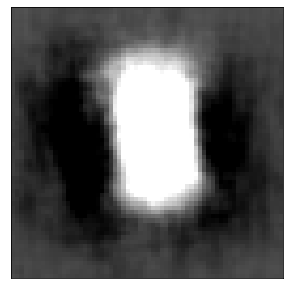

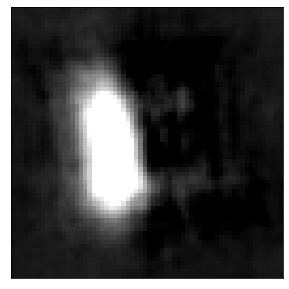

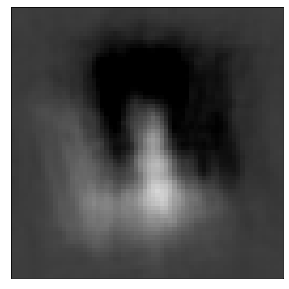

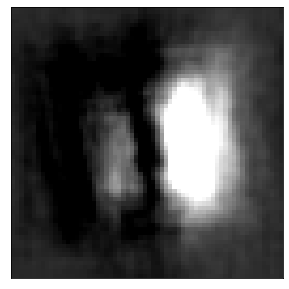

In [97]:
from sklearn.decomposition import PCA, NMF

nmf = NMF(n_components=5)
nmf.fit(X_train)
for princ_comp in nmf.components_:
    print(princ_comp)
    imshow_np(princ_comp)

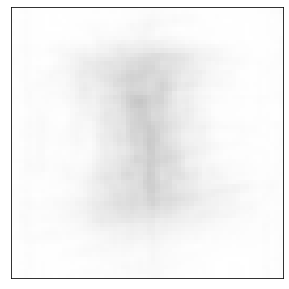

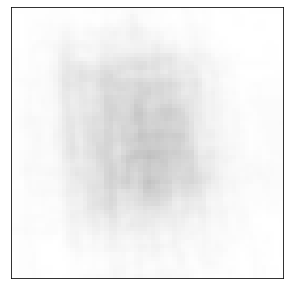

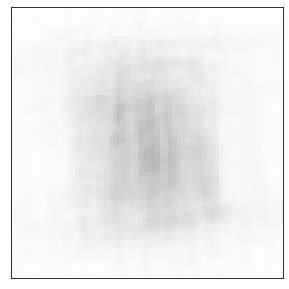

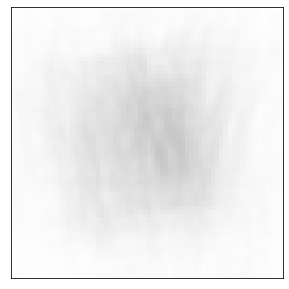

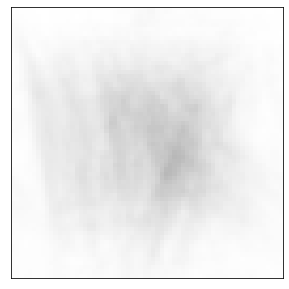

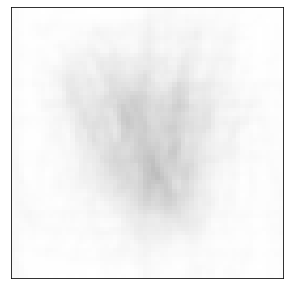

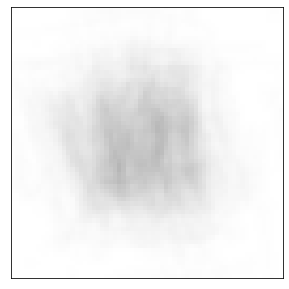

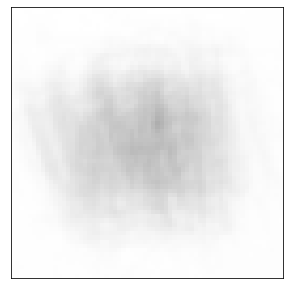

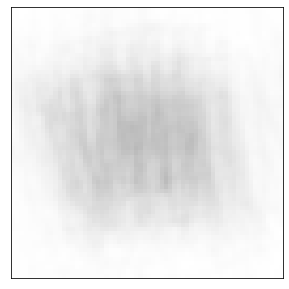

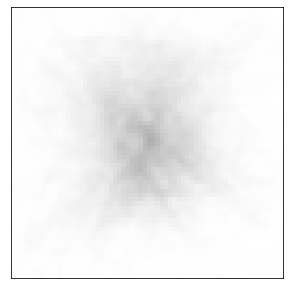

In [94]:
for c in np.unique(y_train):
    imshow_np(X_train[y_train == c].mean(axis=0))